In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

In [26]:
target_file_dir = "../../datas/"
# target_file_names = [
#     "RealEstateData_20111_20164_13_main",
#     "RealEstateData_20171_20234_13_main",
#     "RealEstateData_20111_20234_14_main"
# ]
target_file_names = [
    # "RealEstateData_20121_20154_14_13_main",
    # "RealEstateData_20161_20194_14_13_main",
    # "RealEstateData_20201_20234_14_13_main"
    'RealEstateData_20221_20234_14_40_main'
]
target_file_end = ".csv"
df_origin = pd.DataFrame()
for file_name in target_file_names:
    df = pd.read_csv(target_file_dir + file_name + target_file_end)
    df_origin = pd.concat([df_origin, df], axis=0)

In [13]:
# パラメータ
TradePriceThrethold = 15000
AgeAtTradeThrethold = 50

use_cols_non_cate = ["TradePrice","Area","TradeYear","AgeAtTrade", 'TotalFloorArea', "FloorAreaRatio"] #Municipality Prefecture
category_cols = ['Municipality', 'Structure' ,'Type']

use_cols = use_cols_non_cate + category_cols
AreaThrethold = 200 # if select_type == "宅地(土地と建物)" else 150 if select_type == "中古マンション等" else 0

# データ読み込み
col_choice_extract = (~df_origin.AgeAtTrade.isnull())
col_choice_threthold = (df_origin.TradePrice<TradePriceThrethold)&(df_origin.Area<AreaThrethold)&(df_origin.AgeAtTrade<AgeAtTradeThrethold)
df_base = df_origin.loc[col_choice_extract&col_choice_threthold,use_cols].copy()
print(df_origin.shape[0], df_origin.loc[col_choice_extract,:].shape[0],df_base.shape[0])

451808 433600 402491


In [14]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

df = df_base.copy()

#Municipalityを数字に変換
mapping_dict = {}
for category_col in category_cols:
    df[category_col], mapping_dict[category_col] = pd.factorize(df[category_col]) 

# 目的変数と説明変数に分割
y = df['TradePrice']
X = df.drop('TradePrice', axis=1)

# パラメータの設定
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 63,
    'learning_rate': 0.15,
    'bagging_freq': 1, 
    'feature_fraction': 0.9
}

# 訓練データとテストデータに分割
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
verbose_eval = 1

# テストデータと学習データ分割
# 参考：https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# early_stopping用の評価データをさらに分割
X_train, X_valid, y_train, y_valid = train_test_split(X_train_raw, y_train_raw, test_size=0.2, random_state=42)

###### ここからがLightGBMの実装 ######
# データをDatasetクラスに格納
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=category_cols)  # 学習用
dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=category_cols)  # early_stopping用

# LightGBMモデルの訓練
model = lgb.train(params, dtrain, 
                  num_boost_round=10000, 
                  valid_sets=[dvalid], 
                  callbacks=[lgb.early_stopping(stopping_rounds=20, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval)])

# モデルの評価（MAE）
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
mae = mean_absolute_error(y_test, y_pred)

print('Mean Absolute Error:', mae)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 289792, number of used features: 8
[LightGBM] [Info] Start training from score 3525.610045
[1]	valid_0's l1: 1385.2
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l1: 1290.11
[3]	valid_0's l1: 1165.62
[4]	valid_0's l1: 1102.78
[5]	valid_0's l1: 1011.34
[6]	valid_0's l1: 938.112
[7]	valid_0's l1: 885.769
[8]	valid_0's l1: 832.274
[9]	valid_0's l1: 790.014
[10]	valid_0's l1: 754.602
[11]	valid_0's l1: 725.827
[12]	valid_0's l1: 710.819
[13]	valid_0's l1: 698.996
[14]	valid_0's l1: 679.492
[15]	valid_0's l1: 671.381
[16]	valid_0's l1: 656.225
[17]	valid_0's l1: 644.443
[18]	valid_0's l1: 634.535
[19]	valid_0's l1: 626.56
[20]	valid_0's l1: 619.147
[2

In [ ]:
全部：541
TotalFloorArea抜き: 568
FloorAreaRatio抜き: 559
'CoverageRatio'抜き：545 

In [53]:
# モデルの評価（MAE） FloorAreaRatio
X_test_1 = X_test.query('Type==0')
X_test_m = X_test.query('Type==1')
y_test_1 = y_test[(X_test.Type==0)]
y_test_m = y_test[X_test.Type==1]

for X_test_, y_test_ in [[X_test_1, y_test_1], [X_test_m, y_test_m]]:
    y_pred = model.predict(X_test_, num_iteration=model.best_iteration)
    mae = mean_absolute_error(y_test_, y_pred)
    print(mae) #575

642.723719058127
472.9183625491783


In [9]:
X_test.columns

Index(['Area', 'TradeYear', 'AgeAtTrade', 'TotalFloorArea', 'CoverageRatio',
       'FloorAreaRatio', 'Municipality', 'Structure', 'Type'],
      dtype='object')

In [8]:
model.predict(X_test.query('TradeYear==2020 and Area==65 and AgeAtTrade==9'))

array([4662.21713906, 7918.72990375, 5498.91145036, 4833.89639767])

In [38]:
list(mapping_dict['Structure'])

['ＲＣ',
 'ＳＲＣ',
 '鉄骨造',
 '木造',
 '軽量鉄骨造',
 'ＳＲＣ、ＲＣ',
 'ＲＣ、鉄骨造',
 'ＲＣ、木造',
 'ブロック造',
 '鉄骨造、木造',
 '鉄骨造、軽量鉄骨造',
 'ＲＣ、木造、ブロック造',
 '木造、ブロック造',
 'ＲＣ、軽量鉄骨造',
 '木造、軽量鉄骨造',
 'ＲＣ、ブロック造',
 'ＳＲＣ、鉄骨造',
 'ＳＲＣ、木造',
 'ＳＲＣ、ＲＣ、鉄骨造']

In [39]:
df_test = pd.DataFrame([80,2020,10,100,80,200,32,3,0], 
                       index=['Area', 'TradeYear', 'AgeAtTrade', 'TotalFloorArea', 'CoverageRatio',
       'FloorAreaRatio', 'Municipality', 'Structure', 'Type']).T
model.predict(df_test)

array([4437.55433389])

In [16]:
df_lgbm = pd.read_csv('../../datas/RealEstateData_LGBM.csv')
df_lgbm.shape

(1010880, 10)

Index(['宅地(土地と建物)', '中古マンション等'], dtype='object')

In [15]:
# マンション用
from itertools import product

Type_list = ['宅地(土地と建物)']
Area_list = [x for x in range(20,101,10)] + [150,200]
TradeYear_list = [2015,2020,2025]
AgeAtTrade_list = [0,10,20, 30, 40, 50]
Municipality_list = [x for x in df_origin.Municipality.unique()]
Structure_list = ['木造']
TotalFloorArea_list = [x for x in range(50,201,50)] + [np.nan]
CoverageRatio_list = [60]
FloorAreaRatio_list = [100, 200, 300, 500]
#['1K', '1LDK', '1R', '2LDK', '3LDK', '4LDK']

Tyoe_list_2 = ['中古マンション等']
Area_list_2 = [x for x in range(20,101,10)] + [150, 200]
# Municipality_for_m = df_origin.query('Type=="中古マンション等"').pivot_table(index='Municipality', values='Area', aggfunc='count').sort_values('Area').query('Area>20').index
# Municipality_list_2 = [x for x in Municipality_for_m]
TotalFloorArea_list_2 = [np.nan]
FloorAreaRatio_list_2 = [100, 200, 300, 500]
CoverageRatio_list_2 = [80]
Structure_list_2 = ['ＲＣ']



# TotalFloorArea_list = [0,999]
# CoverageRatio_list = [0,999]
# FloorAreaRatio_list = [0,999]
# CoverageRatio_list_2 = [0,999]
# FloorAreaRatio_list_2 = [0,999]

# 各リストの組み合わせを生成
combinations= list(product(Area_list, TradeYear_list, AgeAtTrade_list, Municipality_list, Structure_list, Type_list,
                            TotalFloorArea_list, CoverageRatio_list, FloorAreaRatio_list))

combinations_2= list(product(Area_list_2, TradeYear_list, AgeAtTrade_list, Municipality_list, Structure_list_2, Tyoe_list_2,
                            TotalFloorArea_list_2, CoverageRatio_list_2, FloorAreaRatio_list_2))

# リストからDataFrameを作成
df = pd.DataFrame(combinations, columns=['Area', 'TradeYear', 'AgeAtTrade', 'Municipality', 'Structure', 'Type', 
                                         'TotalFloorArea','CoverageRatio', 'FloorAreaRatio'])
df2 = pd.DataFrame(combinations_2, columns=['Area', 'TradeYear', 'AgeAtTrade', 'Municipality', 'Structure', 'Type', 
                                         'TotalFloorArea','CoverageRatio', 'FloorAreaRatio'])
df_dummy_m = pd.concat([df,df2]).reset_index(drop=True)
df_dummy_m = df_dummy_m.loc[:,X_test.columns]

# 結果を表示
print(df_dummy_m.shape)

# カテゴリー変数を、モデル作成時の変換マップの値で置換
for category_col in category_cols:
    df_dummy_m[category_col] = df_dummy_m[category_col].map({val: i for i, val in enumerate(mapping_dict[category_col])})

# model.predict(df_dummy_m.tail(50))


(555984, 8)


In [72]:
df_dumm_2 = df_dummy_m.copy()#.query('Type==0 and TradeYear==2020 and  AgeAtTrade<30')
df_dumm_2['TradePrice'] = model.predict(df_dumm_2)
df_dumm_2.shape

(101880, 10)

In [73]:
df_dumm_3 = df_dummy_m.copy().query("TradeYear==2020 and Municipality==32 and FloorAreaRatio==200 and CoverageRatio==60 and AgeAtTrade==10 and Area==80")
df_dumm_3['TradePrice'] = model.predict(df_dumm_3)
df_dumm_3

,Area,TradeYear,AgeAtTrade,TotalFloorArea,CoverageRatio,FloorAreaRatio,Municipality,Structure,Type,TradePrice
35845,80,2020,10,50.0,60,200,32.0,3,0,3053.597968
35846,80,2020,10,100.0,60,200,32.0,3,0,4446.802232
35847,80,2020,10,150.0,60,200,32.0,3,0,6648.165922
35848,80,2020,10,200.0,60,200,32.0,3,0,7450.726543
35849,80,2020,10,NaN,60,200,32.0,3,0,4747.664018
95535,80,2020,10,NaN,60,200,32.0,0,1,5227.034504


In [74]:
df_test

,Area,TradeYear,AgeAtTrade,TotalFloorArea,CoverageRatio,FloorAreaRatio,Municipality,Structure,Type
0,80,2020,10,100,80,200,32,3,0


In [69]:
df_test = pd.DataFrame([80,2020,10,100,80,200,32,3,0], 
                       index=['Area', 'TradeYear', 'AgeAtTrade', 'TotalFloorArea', 'CoverageRatio',
       'FloorAreaRatio', 'Municipality', 'Structure', 'Type']).T
model.predict(df_test)

array([4437.55433389])

In [29]:
df_tmp = df_origin.query('Type=="中古マンション等"')
df_tmp.loc[:,['Area', 'TotalFloorArea']]

,Area,TotalFloorArea
0,65,65.0
3,70,70.0
4,55,55.0
5,60,60.0
6,70,70.0
...,...,...
24237,55,55.0
24238,65,65.0
24239,80,80.0
24240,75,75.0


In [30]:
df_tmp = df_origin[~df_origin.TotalFloorArea.isnull()].copy()
print(df_tmp.shape, df_origin.shape)

(24970, 16) (25463, 16)


<Axes: xlabel='TotalFloorArea'>

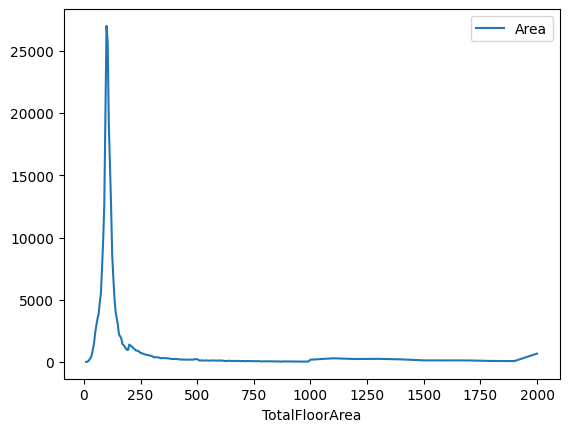

In [24]:
df_tmp = df_origin.query('Type=="宅地(土地と建物)"').copy()
# df_tmp = df_tmp.query('Municipality=="港区"')
df_tmp.pivot_table(index='TotalFloorArea', values='Area', aggfunc='count').plot()

<Axes: xlabel='Area'>

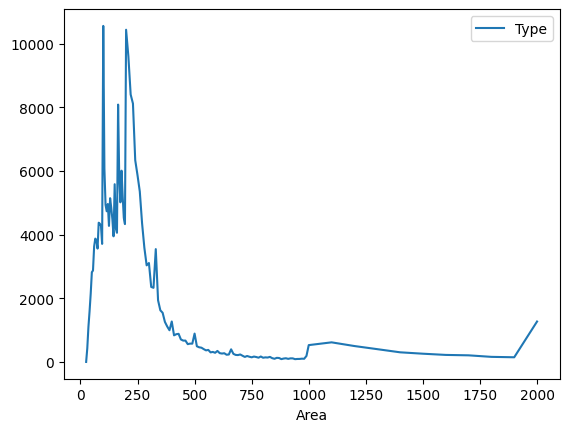

In [25]:
df_tmp.pivot_table(index='Area', values='Type', aggfunc='count').plot()
